In [84]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import Literal
import os
from PIL import Image

In [85]:
def image_to_edged_image(image):
    """Calcule une vision de l'image mettant en valeur les contours.

    Args:
        image (_type_): _description_

    Returns:
        _type_: _description_
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 10, 250)
        
    return edged

In [ ]:
def extract_contours_from_edged_image(edged_image, retrieval_mode = cv2.RETR_EXTERNAL):
    contours, _ = cv2.findContours(edged_image, retrieval_mode, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:6]
    
    return contours

In [87]:
def show_contours(image, contours):
    ncols = 3
    nrows = math.ceil(len(contours) / ncols)
    figsize = (ncols * 6, nrows * 6)
    
    figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    figure.suptitle("Application du contour sur l'image initiale")
    
    for index_contour in range(len(contours)):
        if nrows == 1:
            ax = axes[index_contour % ncols]
        else:
            ax = axes[index_contour // ncols, index_contour % ncols]
        
        contour = contours[index_contour]
        
        contours_points = [(a[0, 0], a[0, 1]) for a in contour]
        
        # Display the image
        ax.imshow(image)

        for point in contours_points:
            ax.plot(point[0], point[1], 'rx')  # 'ro' means red color, circle marker
            
        ax.set_title(label=f"Contour n°{index_contour + 1}")
        
    for ax in axes.flat:
        ax.label_outer()

    plt.show()

In [88]:
def show_selected_contour(image, contour):
    contours_points = [(a[0, 0], a[0, 1]) for a in contour]
    
    # Display the image
    plt.imshow(image)
    
    rectangle = plt.Polygon(contours_points, closed=True, edgecolor='r', fill=None)

    # Add the rectangle to the plot
    plt.gca().add_patch(rectangle)
    
    plt.title(label="Application du contour sur l'image initiale")

    plt.show()

In [ ]:
def select_most_squarred_contour(contours):
    result = []
    
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        
        if len(approx) == 4:
            result.append((contour, approx, peri))
        
    return result

In [90]:
def get_warped_image_from_contour(image, contour, correcteur = 0):
    pts = contour.reshape(4, 2)
        
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    
    # Top Left Corner
    rect[0] = pts[np.argmin(s)] + [correcteur, correcteur]
    
    # Bottom Right Corner
    rect[2] = pts[np.argmax(s)] + [-correcteur, -correcteur]
    diff = np.diff(pts, axis=1)
    
    # Top Right Corner
    rect[1] = pts[np.argmin(diff)] + [-correcteur, correcteur]
    
    # Bottom Left Corner
    rect[3] = pts[np.argmax(diff)] + [correcteur, -correcteur]

    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped

In [91]:
def interpret_image_argument(image_data):
    if isinstance(image_data, str):
        if os.path.exists(image_data):
            return np.array(Image.open(image_data))
        
        raise Exception("Le fichier au chemin spécifié n'existe pas, vérifier le chemin.")
    
    return image_data

In [92]:
def show_squares(squares):
    figure, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
    
    for i, j, square in squares:
        axes[i, j].imshow(square)
        
    plt.show()

In [93]:
def extract_squares(warped):
    squares = []
    
    # Diviser l'image en 8x8 cases
    square_size = warped.shape[0] // 8
    
    for i in range(8):
        for j in range(8):
            x1 = j * square_size
            y1 = i * square_size
            x2 = (j + 1) * square_size
            y2 = (i + 1) * square_size
            square = warped[y1:y2, x1:x2]
            squares.append((i, j, square))

    return squares

In [94]:
def extract_squares_from_image(image_data, display: Literal['show', 'hide'] = 'hide'):
    """Cette fonction prend en entrée soit le chemin vers une image, soit un tableau représentant les pixels de l'image,
    et retourne la liste des tableaux représentant les cases du jeu d'échec sur l'image.

    Args:
        image_data (_type_): _description_
        correcteur (int, optional): _description_. Defaults to 0.

    Returns:
        list: La liste des tableaux représentant les cases du jeu d'échec sur l'image.
    """
    # On extrait du paramètre d'entrée un tableau représentant les pixels de l'image
    image = interpret_image_argument(image_data)
        
    if display == 'show':
        plt.imshow(image)
        plt.title(label='Image initiale', pad=20)
        plt.show()
    
    # On traite l'image initiale pour obtenir une représentation mettant en valeur les contours, bords, et segments
    edged_image = image_to_edged_image(image)
    
    if display == 'show':
        plt.imshow(edged_image)
        plt.title(label='Images mettant en valeur les contours', pad=20)
        plt.show()
    
    # On extrait de l'image traitées les contours fermées avec la plus grande aire
    contours = extract_contours_from_edged_image(edged_image)
    
    if display == 'show':    
       show_contours(image, contours)
       
    # On sélectionne dans la liste des contours le contour avec la forme la plus proche d'un carré    
    contour = select_most_squarred_contour(contours)
    
    if display == 'show':
        show_selected_contour(image, contour)
    
    # On centre l'image sur le contour sélectionné
    warped_image = get_warped_image_from_contour(image, contour)
    
    if display == 'show':
        plt.imshow(warped_image)
        plt.title(label='Images centrées sur le contour du plateau', pad=20)
        plt.show()
    
    # On réapplique les traitements à l'image centrée pour obtenir le contour le plus proche du plateau
    edged_image_bis = image_to_edged_image(warped_image)
    
    if display == 'show':
        plt.imshow(edged_image_bis)
        plt.title(label='Images mettant en valeur les contours', pad=20)
        plt.show()
        
    contours_bis = extract_contours_from_edged_image(edged_image_bis)
    
    if display == 'show':    
       show_contours(warped_image, contours_bis)
       
    contour_bis = select_most_squarred_contour(contours_bis)
    
    if display == 'show':
        show_selected_contour(warped_image, contour_bis)
        
    warped_image_bis = get_warped_image_from_contour(warped_image, contour_bis, correcteur=25)
    
    if display == 'show':
        plt.imshow(warped_image)
        plt.title(label='Images centrées sur le contour du plateau', pad=20)
        plt.show()
        
    squares = extract_squares(warped_image_bis)
    
    if display == 'show':
        show_squares(squares)
        
    for i, j, square in squares:
        filename = os.path.join(
            'chess_piece_model',
            'pre-dataset',
            f'{i}_{j}_{math.floor(np.random.random() * 1e16)}.png'
        )
        plt.imsave(filename, square)
    
    return squares

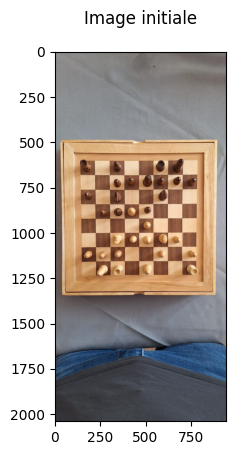

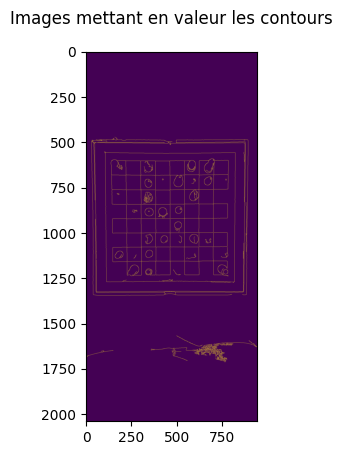

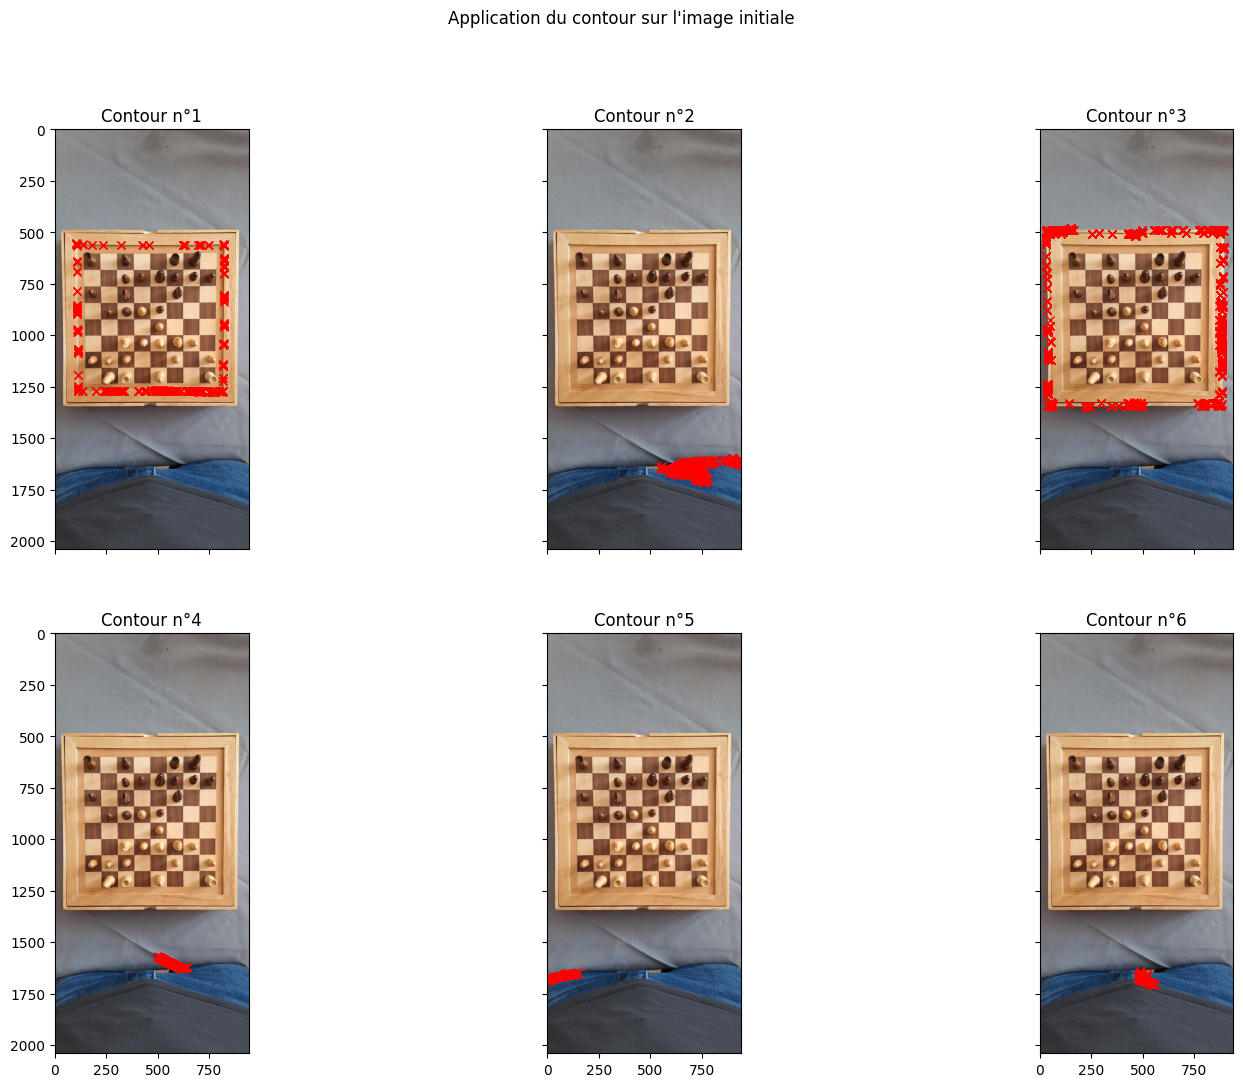

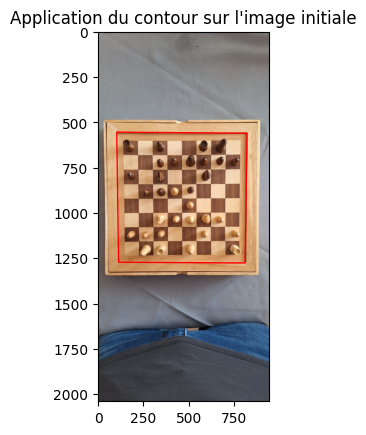

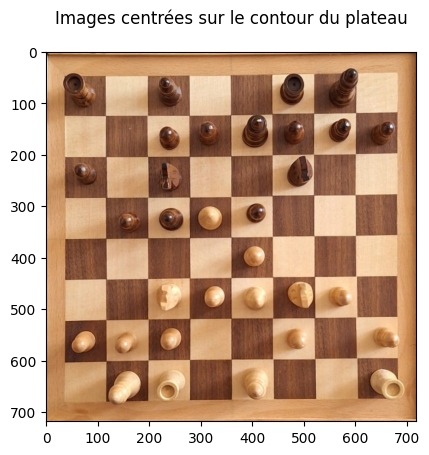

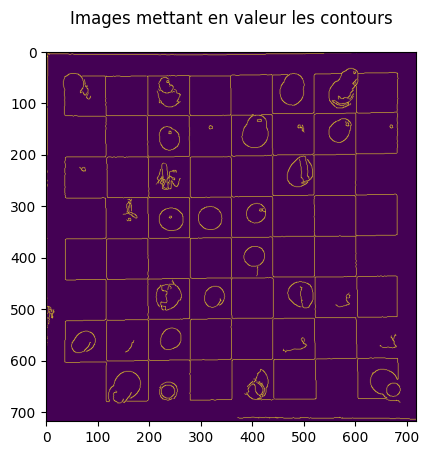

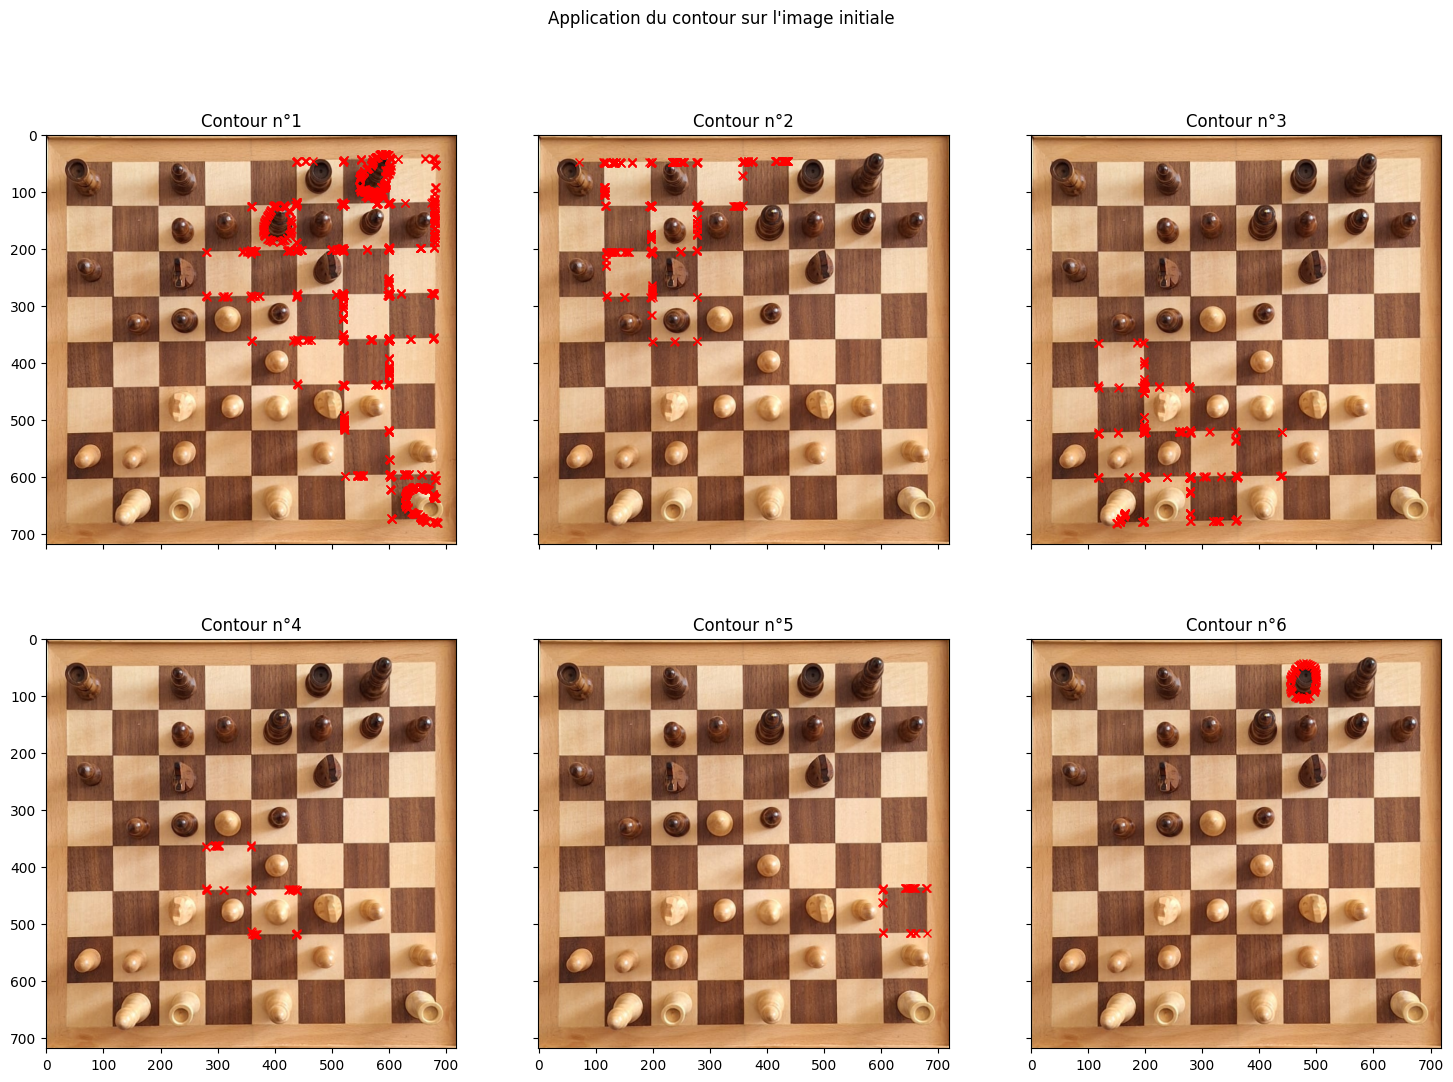

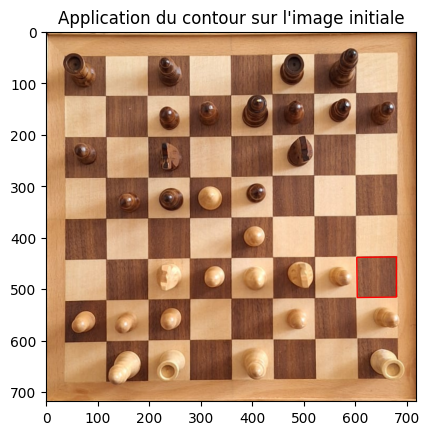

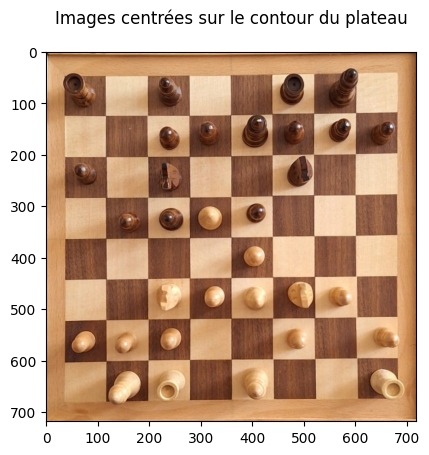

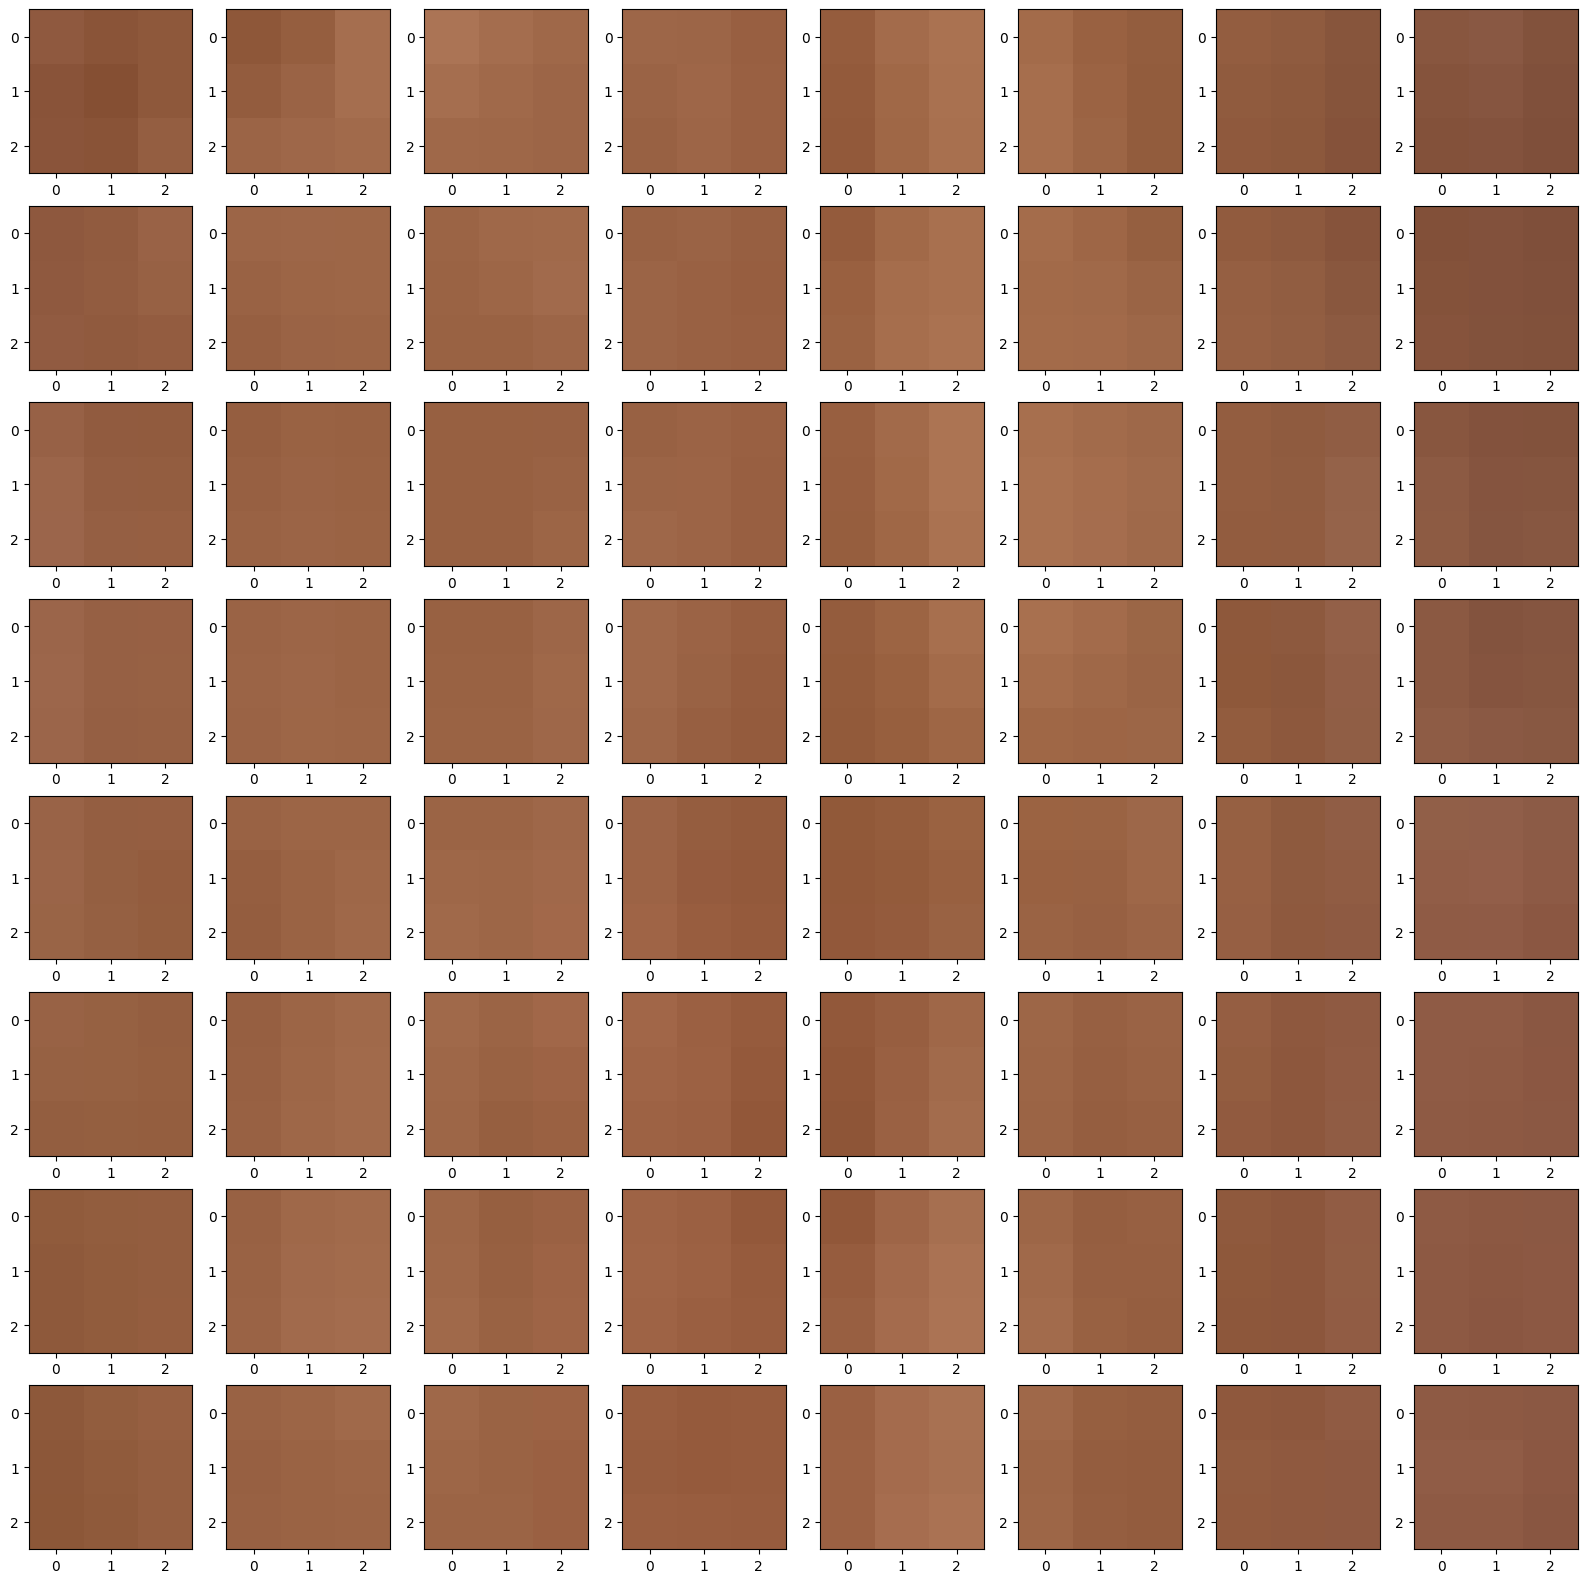

FileNotFoundError: [Errno 2] No such file or directory: 'chess_piece_model\\pre-dataset\\0_0_2526032644706271.png'

In [95]:
image_path = os.path.join(
    '..',
    'assets',
    'WhatsApp Image 2025-03-02 à 13.21.29_d7b3166c.jpg'
)

warped = extract_squares_from_image(image_data=image_path, display='show')